# MAST Plasma Current
Infer plasma current from CCFE's Mega Ampere Spherical Tokamak using discrete magnetic diagnostic data.

## Overview
This notebook addresses the first of three Data Science challenges for the ITER International School 2024.

**Challenge Goal:** Reconstruct plasma current time-series waveforms from the Mega Ampere Spherical Tokamak (MAST) using magnetic field measurements.

The open-source MAST Data Catalog provides all data for this challenge. Credit to Samuel Jackson, Nathan Cummings, Saiful Khan, and the MAST community for creating this FAIR dataset.

## Description
Tokamaks measure plasma current with high precision. In this challenge, you must reconstruct plasma current waveforms by applying machine learning to magnetic diagnostic signals.

We've removed information about the location, orientation, and calibration of diagnostic measurements to prevent using traditional inference techniques.

This challenge presents a labeled regression problem. Your model must transform one-dimensional signals into accurate target waveforms.

The image below shows signals and targets from the first shot in the training dataset: 

![MAST Plasma Signals and Targets](../media/images/plasma_current.png)

### Dataset
The `./fair_mast_data/plasma_current` directory contains data files for the MAST Plasma Current challenge.

#### Files
Both train and test files use a simple CSV format with a single header.

- train.csv - the training dataset
- test.csv - the test dataset

#### Columns
- index - unique identifier for each sample
- time - measurement time in seconds
- XMA_CCBV04:XMA_CCBV36 - magnetic measurements from the center_column group in volts
- XMA_OBR03:XMA_OBR17.1 - magnetic measurements from the outer_discrete group in volts
- plasma_current - target plasma current in kiloamperes (kA)

## Example
The code below demonstrates how to prepare a competition submission. This basic approach provides a starting point that you'll need to improve to achieve competitive scores.

Python libraries are organized at the top in three groups: standard library, third-party packages, and local modules.

In [ ]:
# Standard library imports
import pathlib

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline

### Data Loading
First, we locate the data files. The `train.csv` and `test.csv` files are stored in the `fair_mast_data/plasma_current` directory. We use the `pathlib` library to find these files.

In [5]:
# Set the path to the fair_mast_data directory
path = pathlib.Path().absolute().parent / "fair_mast_data/plasma_current"
print(list(path.glob('*.csv')))


[WindowsPath('c:/Users/mcintos/Code/data_science_challenges/fair_mast_data/plasma_current/test.csv'), WindowsPath('c:/Users/mcintos/Code/data_science_challenges/fair_mast_data/plasma_current/train.csv')]


In [14]:
# Load the data into train and test DataFrames
train = pd.read_csv(path / "train.csv")
test = pd.read_csv(path / "test.csv")

# Print the first few rows of the train DataFrame
print(train.head())


   index     time  XMA_CCBV04  XMA_CCBV12  XMA_CCBV20  XMA_CCBV28  XMA_CCBV36  \
0      0 -0.06560   -0.126953   -0.024414   -0.014648   -0.029297   -0.268555   
1      1 -0.06535   -0.129395   -0.024414   -0.017090   -0.031738   -0.273438   
2      2 -0.06510   -0.129395   -0.024414   -0.017090   -0.034180   -0.275879   
3      3 -0.06485   -0.131836   -0.024414   -0.017090   -0.031738   -0.278320   
4      4 -0.06460   -0.131836   -0.024414   -0.017090   -0.029297   -0.278320   

   XMA_OBR03  XMA_OBR03.1  XMA_OBR06  XMA_OBR06.1  XMA_OBR14  XMA_OBR14.1  \
0  -0.002441    -0.002441  -0.031738    -0.031738  -0.019531    -0.019531   
1  -0.002441    -0.002441  -0.031738    -0.031738  -0.019531    -0.019531   
2  -0.002441    -0.002441  -0.031738    -0.031738  -0.019531    -0.019531   
3  -0.002441    -0.002441  -0.031738    -0.031738  -0.019531    -0.019531   
4  -0.002441    -0.002441  -0.029297    -0.029297  -0.019531    -0.019531   

   XMA_OBR17  XMA_OBR17.1  shot_index  plasma_curr

### Model Pipeline
Create a scikit-learn pipeline to process training and test data consistently. This example uses a minimal pipeline setup.

In [6]:
pipe = sklearn.pipeline.make_pipeline(
    sklearn.linear_model.LinearRegression(),
)

### Data Preparation
We divide the training data into features (X) and target (y), then split into training and validation sets. This example uses all signal columns as features. A thorough understanding of your data before this step significantly improves results.

In [7]:
X, y = train.drop("plasma_current", axis=1), train.plasma_current
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    y,
    test_size=0.3,
    shuffle=True,
    random_state=3,
)

### Model Training
We fit the model to the training set and generate predictions for the validation set.

In [8]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

### Model Evaluation
We evaluate model performance using multiple metrics. While the challenge uses only Mean Absolute Percentage Error (MAPE) for scoring, additional metrics provide valuable insights during development.

- **MAPE (Mean Absolute Percentage Error)**: Measures the average percentage difference between predicted and actual values. Lower values indicate better performance. MAPE is scale-independent, making it useful for comparing performance across different datasets.

- **MAE (Mean Absolute Error)**: Measures the average magnitude of errors between predicted and actual values, without considering their direction. MAE is expressed in the same units as the target variable (kA for plasma current), making it directly interpretable.

In [ ]:
# Calculate Mean Absolute Percentage Error (MAPE)
# Lower values indicate better model performance (0% is perfect)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE {mape:1.3f} (lower is better)")

# Calculate Mean Absolute Error (MAE) in kiloamperes
# This is more intuitive as it's in the same units as plasma current
mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
print(f"MAE {mae:1.3f} kA (lower is better)")

MAPE 5.023
MAE 9.959


### Submission Preparation
After training the model, we prepare a submission file. The Plasma Current challenge requires a CSV file with "index" and "plasma_current" headers followed by predictions.

In [10]:
submission = pd.DataFrame(pipe.predict(test), columns=["plasma_current"])
submission.index.name = "index"
submission.to_csv(path / "linear_regression.csv")

### Visualization and Analysis
Visualizing predictions against validation data helps evaluate performance. Since the competition includes multiple plasma pulses, displaying individual waveforms improves interpretation. We first reorder the dataset that was shuffled during splitting.

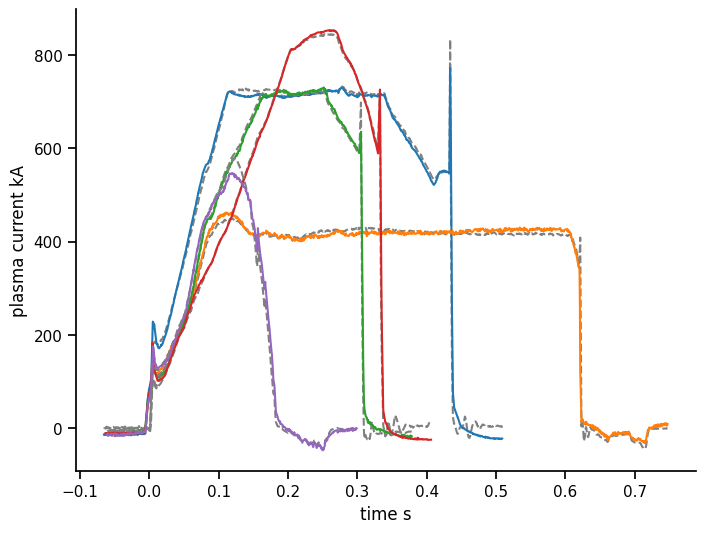

In [12]:
sns.set_context("notebook")
axes = plt.subplots(figsize=(8, 6))[1]

sort_index = np.argsort(X_test.time)
_X_test = X_test.iloc[sort_index]
_y_test = y_test.iloc[sort_index]
for shot_index in np.unique(X_train.shot_index):
    index = _X_test.shot_index == shot_index
    axes.plot(_X_test.loc[index, "time"], _y_test.loc[index], "--", color="gray")
    axes.plot(_X_test.loc[index, "time"], pipe.predict(_X_test)[index])
axes.set_xlabel("time s")
axes.set_ylabel("plasma current kA")
sns.despine()

### Critical Assessment
The plot compares actual plasma current (gray dashed lines) with model predictions (colored lines). Consider these key questions:

1. Do the predictions match your expectations?
2. How accurately does the model fit the data?
3. Is there data leakage between training and validation sets?
4. What methods could fix potential leakage issues?

Your final ranking depends on your score on the private leaderboard section, which uses a hidden evaluation dataset.